# Model Training

## Reading Data

* Here, Athena with awswrangler lib is used to query from Glue Table

In [8]:
import boto3
import awswrangler as wr

In [9]:
session = boto3.session.Session()

In [10]:
df = wr.athena.read_sql_table(table='beer_cleaned_dev', database='random-beer-database', boto3_session=session)

In [11]:
df.head()

,id,name,abv,ibu,target_fg,target_og,ebc,srm,ph,partition_0,partition_1,partition_2,partition_3
0,171,Challenger,6.7,67.0,1013,1064.0,19.0,9.5,4.4,2021,04,07,17
1,102,Peach Therapy,9.0,30.0,1000,1071.0,12.0,6.0,3.6,2021,04,08,11
2,110,Truffle and Chocolate Stout - B-Sides,5.6,30.0,1015,1058.0,54.0,27.0,4.4,2021,04,08,08
3,84,Baby Saison - B-Sides,3.6,9.0,1004,1032.0,2.0,1.0,4.4,2021,04,08,11
4,78,AB:18,11.8,80.0,1020,1096.0,115.0,57.5,5.2,2021,04,08,08


## Cleaning data

* Some pre processing steps to clean data for model training. I performed these steps:
    * Drop duplicated rows, since Punk API random queries potentially duplicated registers
    * Drop records with _null_ ibu, because it will be the label and it needs to have a proper value
    * Drop records with ibu outliers (above 1000), because these values are probably for marketing purposes

In [12]:
columns = ['id','name','abv','ibu','target_fg','target_og','ebc','srm','ph']
df = df[columns]

In [13]:
df = df.drop_duplicates()

In [14]:
df.shape

(226, 9)

In [15]:
df.describe()

,id,abv,ibu,target_fg,target_og,ebc,srm,ph
count,226.000000,226.000000,221.000000,225.000000,225.000000,221.000000,221.000000,224.000000
mean,159.659292,7.675088,65.957014,1014.800000,1064.772000,60.191403,30.589864,4.392857
std,91.823666,5.126127,106.644819,14.014342,27.120939,76.835615,38.606541,0.349815
min,1.000000,0.500000,8.000000,1000.000000,1007.000000,2.000000,1.000000,3.200000
25%,82.500000,5.025000,35.000000,1010.000000,1048.000000,15.000000,8.000000,4.375000
50%,160.000000,6.850000,50.000000,1012.000000,1064.000000,28.000000,15.000000,4.400000
75%,235.750000,8.200000,70.000000,1015.000000,1076.000000,67.000000,40.000000,4.400000
max,325.000000,55.000000,1157.000000,1120.000000,1157.000000,400.000000,200.000000,5.300000


In [16]:
df.isnull().sum()

id           0
name         0
abv          0
ibu          5
target_fg    1
target_og    1
ebc          5
srm          5
ph           2
dtype: int64

In [17]:
df = df[~df.ibu.isnull()]

In [18]:
df.isnull().sum()

id           0
name         0
abv          0
ibu          0
target_fg    0
target_og    0
ebc          3
srm          3
ph           1
dtype: int64

In [19]:
df.target_fg = df.target_fg.astype(int)

<AxesSubplot:>

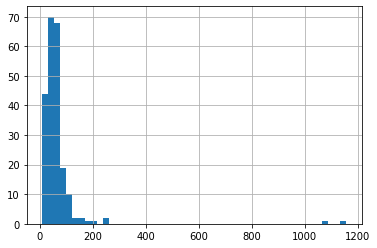

In [20]:
df.ibu.hist(bins=50)

In [21]:
df = df[df.ibu < 1000]

<AxesSubplot:>

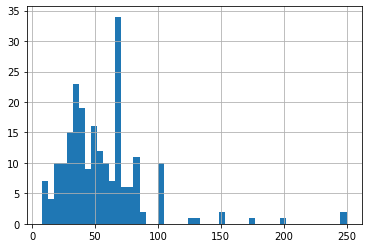

In [22]:
df.ibu.hist(bins=50)

# Model Training and Evaluation

* Here are the steps for model training and evaluation
    * Creation of features and label datasets
    * XGBoost is the chosen model because not only it is generally a good performing model, but it deals with _null_ feature values, so that I don't need to worry about a feature value not showing from Punk API.
    * 5 fold cross validation for a better performance estimation in a production environment
    * RMSE value reported because this metric have same unit as label (IBU)

In [23]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

/home/afonso/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
features = ['abv','target_fg','target_og','ebc','srm','ph']
label = ['ibu']
X = df[features]
y = df[label]

In [25]:
model = xgboost.XGBRegressor(n_estimators=500, max_depth=3)
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
results = cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error') * -1
print(results)
print("RMSE: %.2f (%.2f)" % (results.mean(), results.std()))

[20.67264266 36.6163092  36.96849923 45.46774803 27.96804216]
RMSE: 33.54 (8.49)


# Model training for production

* For production, I used all data to train the final model
* Model is uploaded to a s3 bucket so that it can be fetched in the production environment. This is a simple solution, in the real world we would need a model versioning framework (such as MLFlow)
* This model wouldn't be put in production in the real world, because its conception has several flaws. It's just a toy example so that we can test MLOps concepts.

In [33]:
X_array = X.values
y_array = y.values

model = xgboost.XGBRegressor(n_estimators=500, max_depth=3)
model.fit(X_array, y_array)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
import tempfile
import os
import joblib

s3 = boto3.client('s3')

with tempfile.TemporaryDirectory() as tmpdirname:
    model_path = os.path.join(tmpdirname,'model.joblib')
    joblib.dump(model, model_path) 
    
    dataset_path = os.path.join(tmpdirname,'model_dataset.csv')
    dataset = df.to_csv(dataset_path, index=False)
    
    s3.upload_file(model_path, 'beer-model-artifacts', 'model.joblib')
    s3.upload_file(dataset_path, 'beer-model-artifacts', 'model_dataset.csv')

In [36]:
s3.download_file('beer-model-artifacts', 'model.joblib', 'model.joblib')
model = joblib.load('model.joblib')
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
import numpy as np
example = np.array([6.7,1013,1064.0,19.0,9.5,4.4]).reshape(1, -1)

In [48]:
model.predict(example)

array([67.07364], dtype=float32)